In [ ]:
!pip install tensorflow
!pip install opencv_python
!pip install numpy
!pip install matplotlib

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import os
import datetime

In [12]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
#download the dataset
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

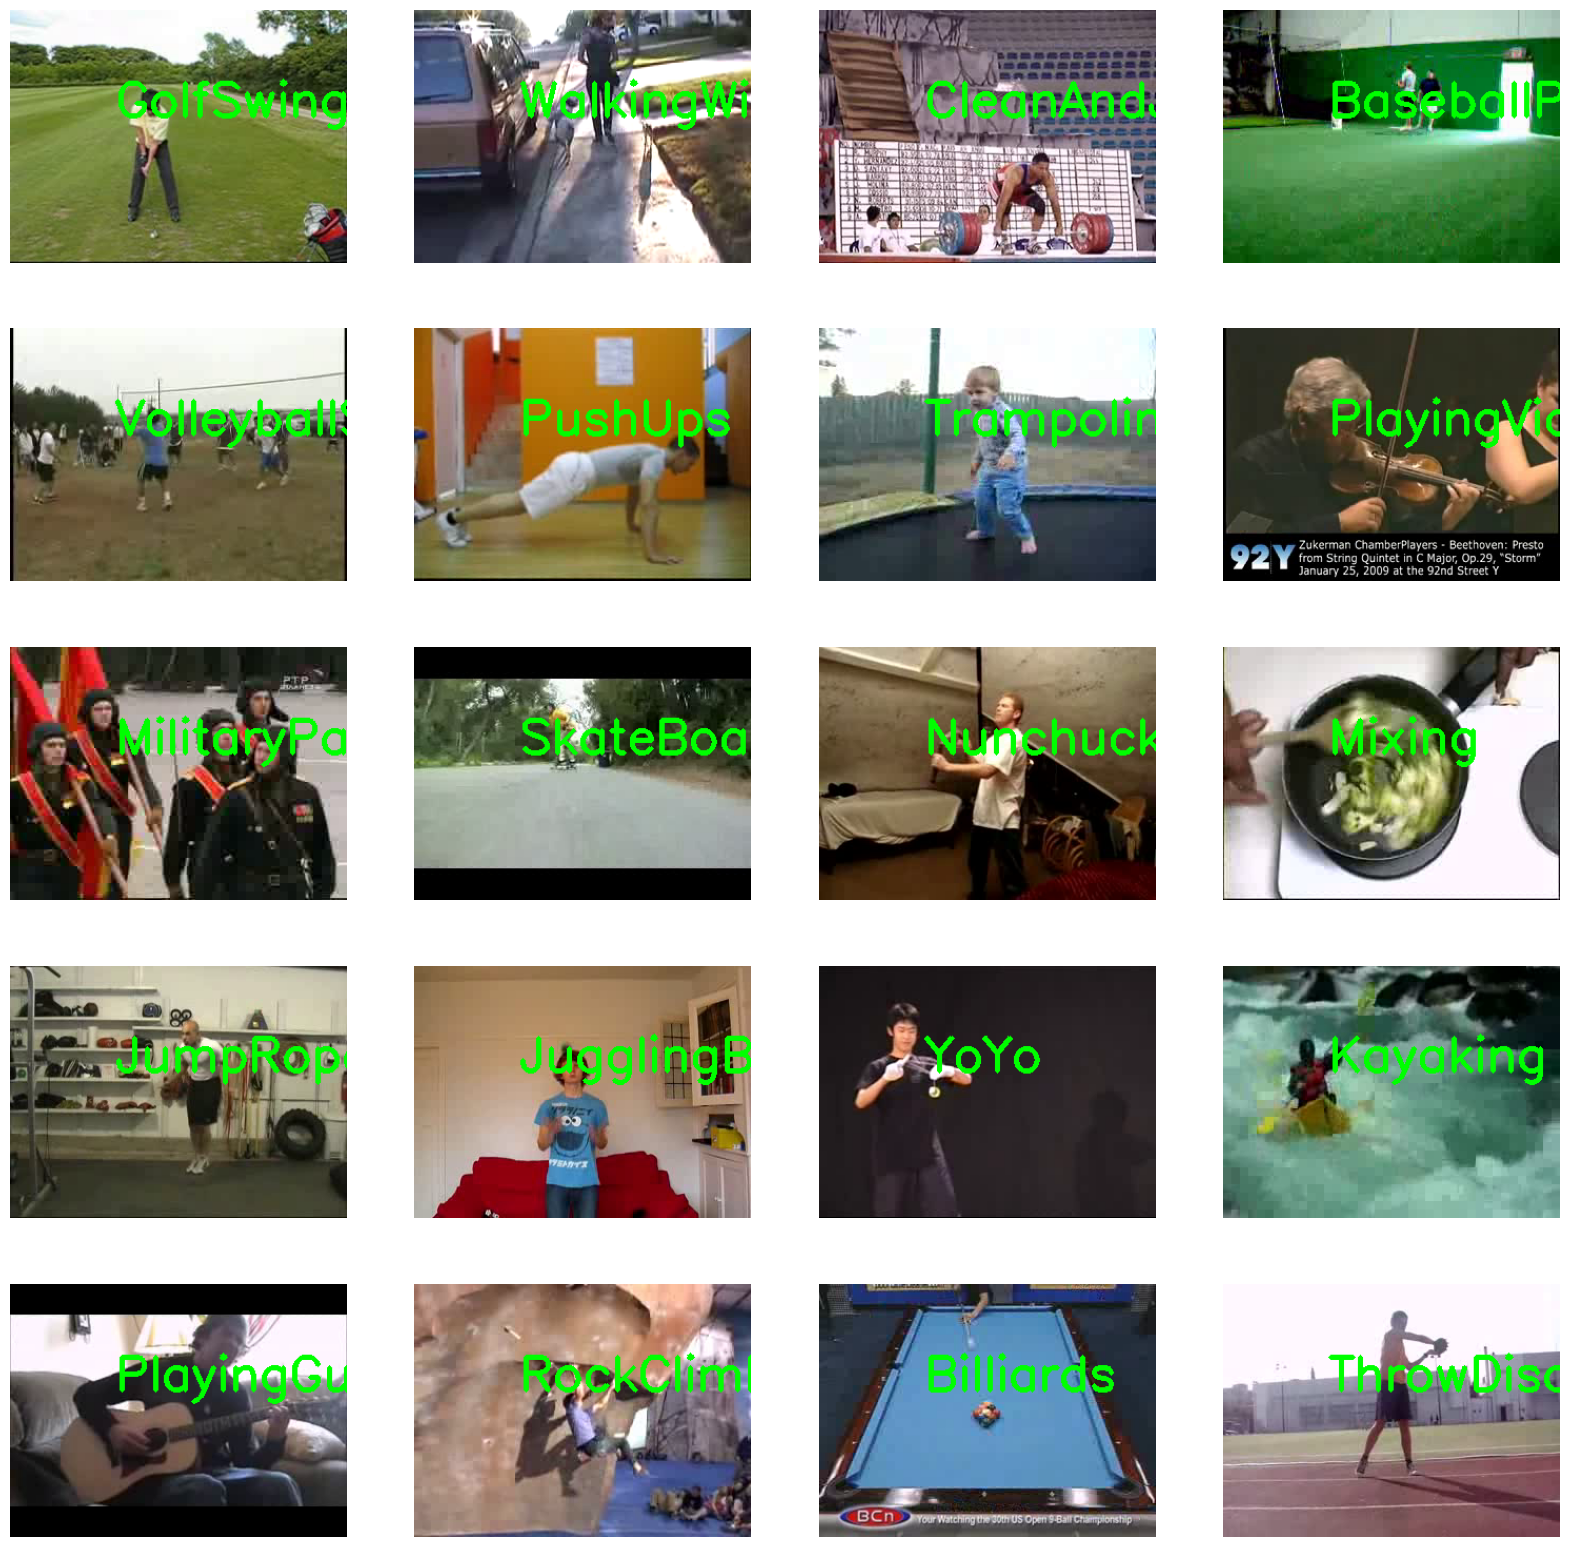

In [14]:
plt.figure(figsize=(20,20))
class_name = os.listdir('/content/UCF50')
random_range = random.sample(range(len(class_name)),20)
for counter , rand_in in enumerate(random_range):
  selected_class = class_name[rand_in]
  video = os.listdir(f'/content/UCF50/{selected_class}')
  selected_video = random.choice(video)
  cap = cv2.VideoCapture(f'/content/UCF50/{selected_class}/{selected_video}')
  _ , bgr = cap.read()
  cap.release()
  rgb = cv2.cvtColor(bgr,cv2.COLOR_BGR2RGB)
  cv2.putText(rgb,selected_class,(100,100),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),4)
  plt.subplot(5,4,counter+1)
  plt.imshow(rgb)
  plt.axis('off')

In [15]:
height , width = 64 , 64
sequence_le = 20
dataset_dir = '/content/UCF50/'
class_lis = ["WalkingWithDog" , "Lunges" , "PullUps" , "Punch"]


In [16]:
# Extracting frame function
def extract_frames(video_path):
  cap = cv2.VideoCapture(video_path)
  frame_len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frames = []
  window = max(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/sequence_le),1)
  for frames_ in range(sequence_le):
    cap.set(cv2.CAP_PROP_POS_FRAMES , frames_ * window)
    _ , frame = cap.read()
    frame = cv2.resize(frame,(height,width))
    if not _:
      break
    frame = frame/255
    frames.append(frame)
  cap.release()
  return frames


In [17]:
def create_dataset(DataSet_Dir , class_list):
  features = []
  labels = []
  video_file_paths = []

  for class_index , class_name in enumerate(class_lis):
    print(f"Proccesing class : {class_name}")
    videos = os.listdir(os.path.join(DataSet_Dir , class_name))
    for video in videos:
      video_path = os.path.join(DataSet_Dir , class_name , video)
      frames = extract_frames(video_path)
      if len(frames)==sequence_le:
        features.append(frames)
        labels.append(class_index)
        video_file_paths.append(video_path)
  features = np.array(features)
  labels = to_categorical(labels)

  return features , labels , video_file_paths

In [18]:
features , labels , _ = create_dataset('/content/UCF50' , class_list=class_lis)


Proccesing class : WalkingWithDog
Proccesing class : Lunges
Proccesing class : PullUps
Proccesing class : Punch


In [19]:
features.shape

(544, 20, 64, 64, 3)

In [20]:
labels.shape

(544, 4)

In [21]:
from sklearn.model_selection import train_test_split
x , y = features , labels
train_x , test_x , train_y , test_y  = train_test_split(x,y,test_size = 0.25 , shuffle = True , random_state = seed_constant)

ConLSTM MODEL

In [22]:
def create_CovLSTM2D():
  model = Sequential()

  #####################################################################################

  model.add(ConvLSTM2D(filters=4 , input_shape = (sequence_le,height,width,3), kernel_size=(3,3), padding='same', return_sequences=True , recurrent_dropout=0.25 , activation='tanh'))
  model.add(MaxPool3D(pool_size=(1,2,2) , padding='same',data_format='channels_last')) # Removed invalid arguments
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(ConvLSTM2D(filters=8 , input_shape = (sequence_le,height,width,3), kernel_size=(3,3), padding='same', return_sequences=True , recurrent_dropout=0.25 , activation='tanh'))
  model.add(MaxPool3D(pool_size=(1,2,2) , padding='same',data_format='channels_last' )) # Removed invalid arguments
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(ConvLSTM2D(filters=10 , input_shape = (sequence_le,height,width,3), kernel_size=(3,3), padding='same', return_sequences=True , recurrent_dropout=0.25 , activation='tanh'))
  model.add(MaxPool3D(pool_size=(1,2,2) , padding='same',data_format='channels_last' )) # Removed invalid arguments
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(ConvLSTM2D(filters=14 , input_shape = (sequence_le,height,width,3), kernel_size=(3,3), padding='same', return_sequences=True , recurrent_dropout=0.25 , activation='tanh'))
  model.add(MaxPool3D(pool_size=(1,2,2) , padding='same',data_format='channels_last')) # Removed invalid arguments
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(ConvLSTM2D(filters=16 , input_shape = (sequence_le,height,width,3), kernel_size=(3,3), padding='same', return_sequences=True , recurrent_dropout=0.25 , activation='tanh'))
  model.add(MaxPool3D(pool_size=(1,2,2) , padding='same',data_format='channels_last' )) # Removed invalid arguments
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(ConvLSTM2D(filters=18 , input_shape = (sequence_le,height,width,3), kernel_size=(3,3), padding='same', return_sequences=True , recurrent_dropout=0.25 , activation='tanh'))
  model.add(MaxPool3D(pool_size=(1,2,2) , padding='same',data_format='channels_last')) # Removed invalid arguments

  model.add(Flatten())

  model.add(Dense(len(class_lis),activation='softmax'))
  model.summary()
  return model

In [23]:
model = create_CovLSTM2D()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 64, 64, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 32, 32, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 32, 32, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 32, 32, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 16, 16, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 16, 16, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 16, 16, 10)      │           6,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 8, 8, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 8, 8, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 8, 8, 14)        │          12,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 4, 4, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 4, 4, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 20, 4, 4, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 20, 2, 2, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 2, 2, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)           │ (None, 20, 2, 2, 18)        │          22,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 20, 1, 1, 18)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 360)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           1,444 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,076 (250.30 KB)

 Trainable params: 64,076 (250.30 KB)

 Non-trainable params: 0 (0.00 B)

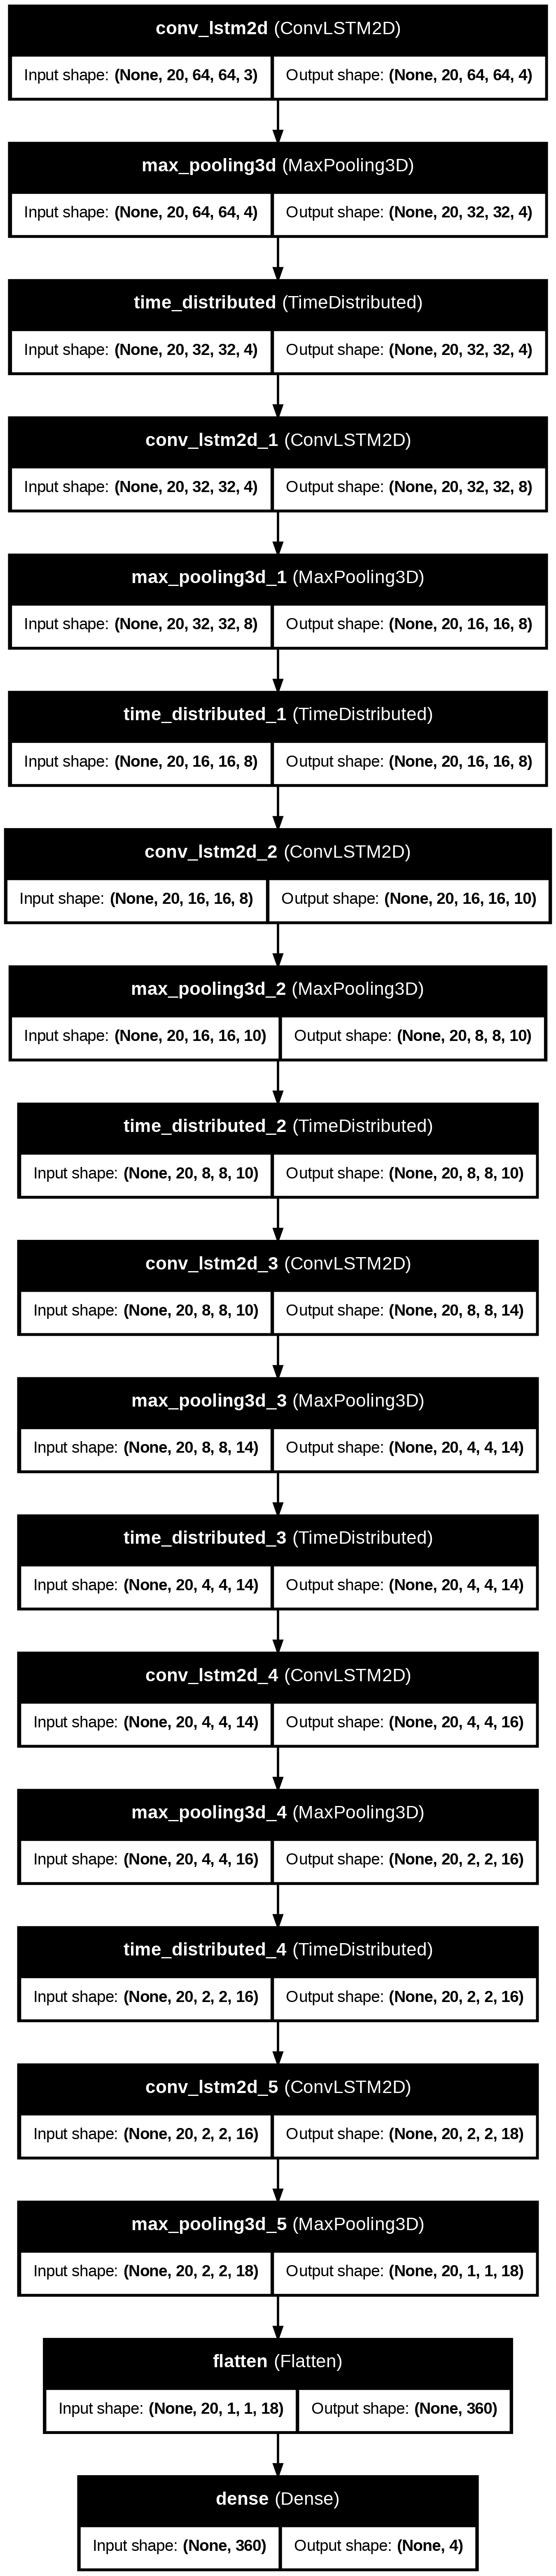

In [ ]:
plot_model(model,to_file="model.png",show_shapes=True,show_layer_names=True)

In [24]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=20 , mode='min',restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
trained_model = model.fit(train_x , train_y , epochs=50 , batch_size=4 , shuffle=True , validation_split=0.2,callbacks=[early_stopping_callback])


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.2464 - loss: 1.3860 - val_accuracy: 0.2561 - val_loss: 1.4251
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.3297 - loss: 1.3655 - val_accuracy: 0.3780 - val_loss: 1.2103
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.4362 - loss: 1.1394 - val_accuracy: 0.3659 - val_loss: 1.2159
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.5180 - loss: 1.1158 - val_accuracy: 0.4634 - val_loss: 1.0341
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5787 - loss: 1.0134 - val_accuracy: 0.5122 - val_loss: 1.0099
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6005 - loss: 0.9802 - val_accuracy: 0.5854 - val_loss: 0.9885
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6070 - loss: 0.9454 - val_accuracy: 0.5488 - val_loss: 1.0229
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6619 - loss: 0.9028 - val_accuracy: 0.6341 

In [25]:
model_evaluation = model.evaluate(test_x , test_y)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 778ms/step - accuracy: 0.6118 - loss: 1.2457


In [26]:
def plot_metrics(model_history,metrix_1,metrix_2,plot_name):
  val_1 = model_history.history[metrix_1]
  val_2 = model_history.history[metrix_2]
  epochs = range(1,len(val_1)+1)

  plt.plot(epochs,val_1,'b',label='Training '+metrix_1)
  plt.plot(epochs,val_2,'r',label='Validation '+metrix_2)

  plt.title(plot_name)
  plt.legend()
  plt.show()

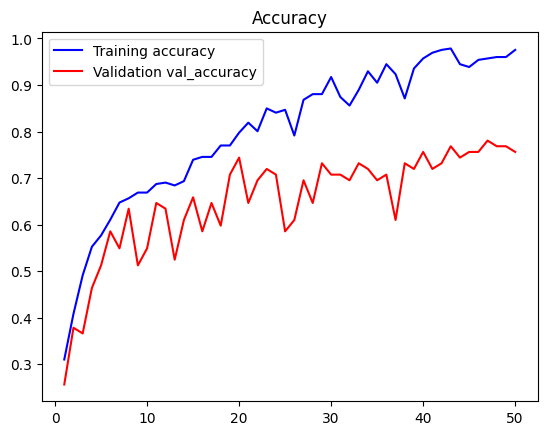

In [27]:
plot_metrics(trained_model,'accuracy','val_accuracy','Accuracy')

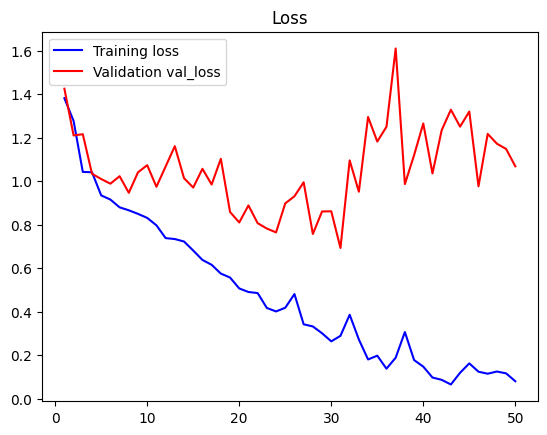

In [28]:
plot_metrics(trained_model,'loss','val_loss','Loss')

# **LRCN METHOD**

In [29]:
def create_LRCN():
  model = Sequential()
    #####################################################################################

  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),input_shape = (sequence_le,height,width,3)))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dense(len(class_lis),activation='softmax'))
  ####################################################################################
  model.summary()
  return model

In [30]:
model_LRCN = create_LRCN()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_5 (TimeDistributed) │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 32, 32, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 32, 32, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 32, 32, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 16, 16, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 16, 16, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 16, 16, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 20, 8, 8, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 20, 8, 8, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 20, 8, 8, 64)        │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 20, 4, 4, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 20, 4, 4, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 20, 1024)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │         135,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195,940 (765.39 KB)

 Trainable params: 195,940 (765.39 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=20 , mode='min',restore_best_weights=True)
model_LRCN.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
trained_model_LRCN = model_LRCN.fit(train_x , train_y , epochs=50 , batch_size=4 , shuffle=True , validation_split=0.2,callbacks=[early_stopping_callback])


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - accuracy: 0.3306 - loss: 1.3674 - val_accuracy: 0.4268 - val_loss: 1.1007
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4943 - loss: 1.0561 - val_accuracy: 0.4390 - val_loss: 1.1744
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.5180 - loss: 1.0407 - val_accuracy: 0.4878 - val_loss: 1.0508
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5736 - loss: 0.9438 - val_accuracy: 0.4634 - val_loss: 1.0273
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.5562 - loss: 0.9590 - val_accuracy: 0.5000 - val_loss: 1.0125
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.6492 - loss: 0.8482 - val_accuracy: 0.5854 - val_loss: 0.8904
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7210 - loss: 0.7647 - val_accuracy: 0.4512 - val_loss: 1.1002
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6679 - loss: 0.8184 - val_accuracy: 0.6585

In [32]:
model_LRCN_evaluation = model_LRCN.evaluate(test_x , test_y)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8043 - loss: 0.6993


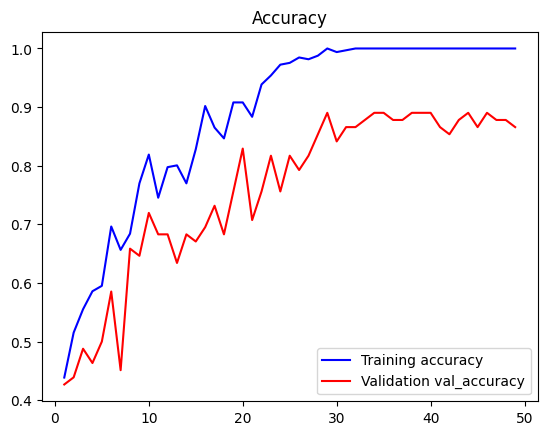

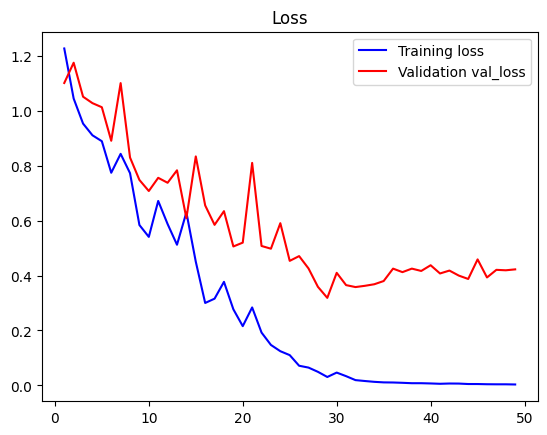

In [33]:
plot_metrics(trained_model_LRCN,'accuracy','val_accuracy','Accuracy')
plot_metrics(trained_model_LRCN,'loss','val_loss','Loss')


In [ ]:
import tensorflow as tf

def convert_to_tflite(trained_model, output_filename="model.tflite"):
    """
    Converts a trained Keras model to TFLite format.

    Args:
        trained_model (tf.keras.Model): Trained Keras model.
        output_filename (str): Filename for the saved TFLite model.

    Returns:
        None
    """
    # Initialize the TFLite converter
    converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)

    # Optional: Set optimizations (e.g., for size or latency)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Convert the model
    tflite_model = converter.convert()

    # Save the TFLite model
    with open(output_filename, "wb") as f:
        f.write(tflite_model)

    print(f"TFLite model saved to {output_filename}")

# Example usage (for LRCN model):
# model = create_LRCN()
# model.load_weights("lrcn_weights.h5")  # Load trained weights
# convert_to_tflite(model, "lrcn_model.tflite")

In [37]:
import cv2
import numpy as np

def test(video_pth, model):
    """
    Recognizes actions in real-time from a video and saves the output video.

    Args:
        video_pth (str): Path to the input video file.
        model (tf.keras.Model): Trained Keras model for action recognition.
    """
    cap = cv2.VideoCapture(video_pth)
    cnt = -1
    frames = []

    # Get video properties for output video
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        frame_resized = cv2.resize(frame, (64, 64))
        frame_normalized = frame_resized / 255.0

        cnt += 1
        if cnt == 20:
            realtime_features = []
            realtime_features.append(frames)
            features = np.array(realtime_features)

            # Perform action recognition
            prediction = model.predict(features)[0]
            predicted_class_index = np.argmax(prediction)
            predicted_class_label = class_lis[predicted_class_index]  # Assuming class_lis is defined

            # Add prediction text to the frame
            cv2.putText(frame, predicted_class_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            cnt = -1
            frames = []
        else:
            frames.append(frame_normalized)

        # Write the frame to the output video
        out.write(frame)


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Example usage:
test('/content/UCF50/Lunges/v_Lunges_g06_c04.avi', model_LRCN)  # Use your trained LRCN model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
